<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the <b>delta_two_lorentz</b> model .
</div>

The data are two sets of water data measured at IN5 (ILL) using two different wavelengths.

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

# the following two lines are to remove the warning about too many figures open simultaneously
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps
    
# check version of bumps installed
# Information message if installed version not recent enough
import bumps

from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

In [3]:
# install QENSmodels (if not already installed)

if not pkgutil.find_loader("QENSmodels"):
    !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

In [4]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Data
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r')
hw_5A = f['entry1']['data1']['X'][:]
q_5A = f['entry1']['data1']['Y'][:]
sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
err_5A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_8A.hdf', 'r')
hw_8A = f['entry1']['data1']['X'][:]
q_8A = f['entry1']['data1']['Y'][:]
sqw_8A = np.transpose(f['entry1']['data1']['DATA'][:])
err_8A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Resolution
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'V_273K_5A.hdf', 'r')
res_5A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'V_273K_8A.hdf', 'r')
res_8A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
# 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:,i], hw_5A)
    res_5A[:,i] /= area 
    
# 8 Angstrom
for i in range(len(q_8A)):
    area = simps(res_8A[:,i], hw_8A)
    res_8A[:,i] /= area
    
# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
idx_8A = np.where(np.logical_and(hw_8A > -1.0, hw_8A < 1.0))

def model_convol(x, q, scale=1, center=0, A0=1.0, A1=1.0, hwhm1=1.0, hwhm2=1.0, resolution=None):
    model = QENSmodels.sqwDeltaTwoLorentz(x, q, scale, center, A0, A1, hwhm1, hwhm2)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # Teixeira model    
    Mq = Curve(model_convol, x, data, error, q=q_5A[i],
               scale=20, center=0.0, A0=0.0, A1=0.9, hwhm1=0.05, hwhm2=0.3, 
               resolution=resol)
    # Fitted parameters    
    Mq.scale.range(1.e-12, 20)
    Mq.center.range(-0.1, 0.1)
    Mq.A0.range(0, 0.05)
    Mq.A1.range(0, 1)
    Mq.hwhm1.range(0, 0.5)
    Mq.hwhm2.range(0, 3)
    
    # Q-independent parameters
    if i == 0:
        QA0 = Mq.A0
    else:
        Mq.A0 = QA0
   
    M.append(Mq)
    
# Second dataset: wavelength=8 Angstrom
for i in range(len(q_8A)):

    x = hw_8A[idx_8A]
    data = sqw_8A[idx_8A, i]
    error = err_8A[idx_8A, i]
    resol = res_8A[idx_8A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    
    Mq = Curve(model_convol, x, data, error, q=q_8A[i],
               scale=35, center=0.0, A0=0.0, A1=0.9, hwhm1=0.05, hwhm2=0.3, 
               resolution=resol)

    # Fitted parameters    
    Mq.scale.range(0.1, 40)
    Mq.center.range(-0.1, 0.1)
    Mq.A0.range(0, 0.05)
    Mq.A1.range(0, 1)
    Mq.hwhm1.range(0, 0.5)
    Mq.hwhm2.range(0, 3)
    
    # Q-independent parameters
    if i == 0:
        QA0 = Mq.A0
    else:
        Mq.A0 = QA0
          
    M.append(Mq) 
    
problem = FitProblem(M)

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description='Minimizer:', options={'Levenberg-Marquardt': 'lm', 'Nelder-Mead Simplex': 'amoeba', 'DRE…

<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 500

Initial chisq 20737.440(31)


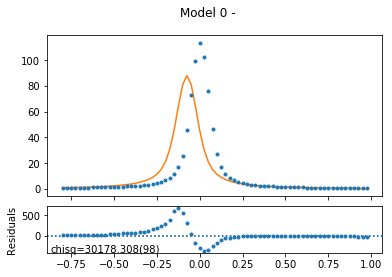

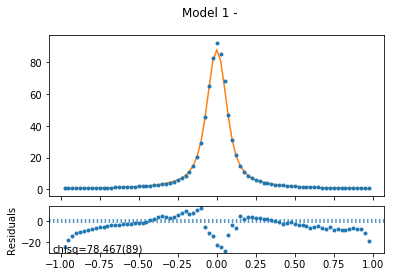

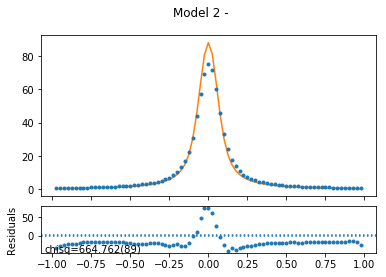

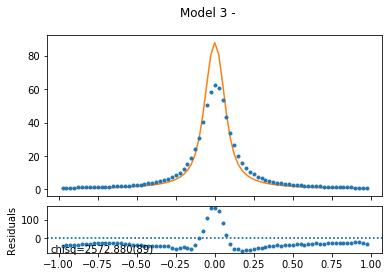

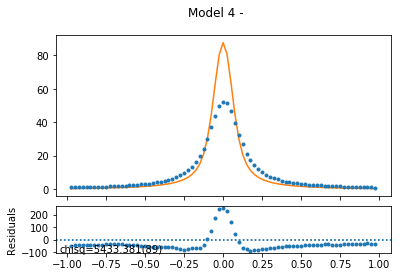

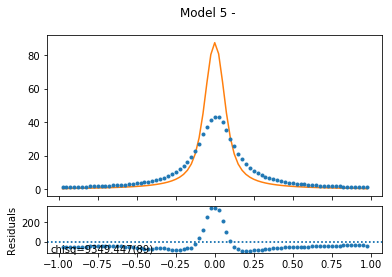

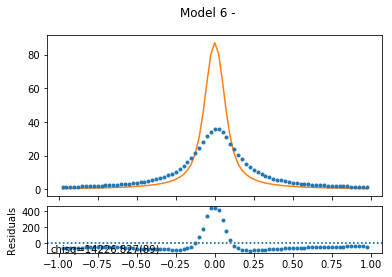

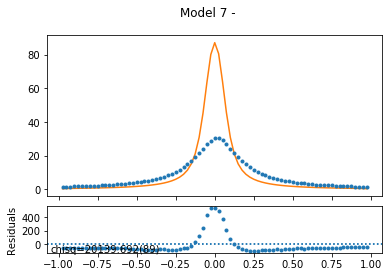

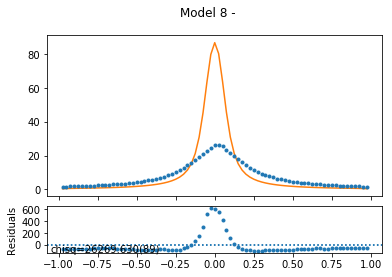

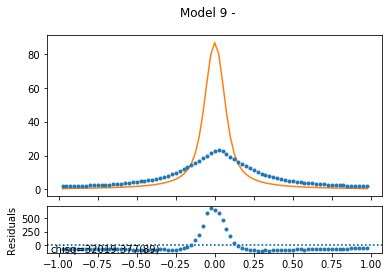

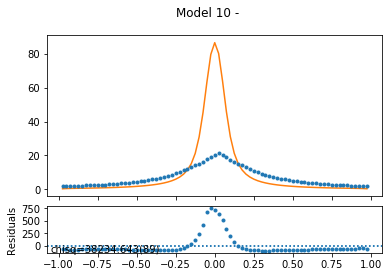

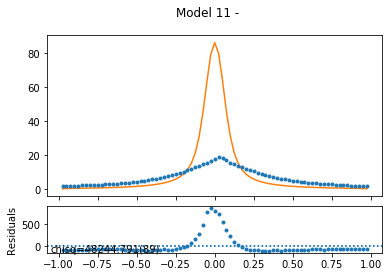

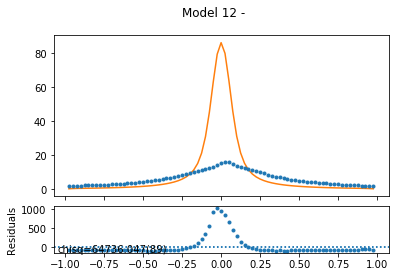

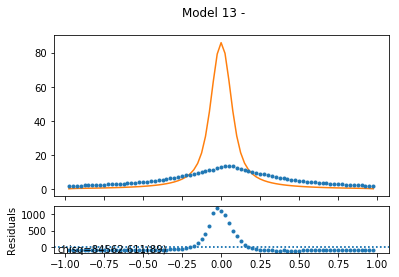

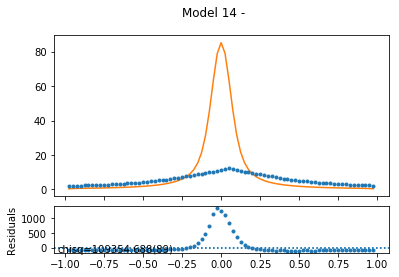

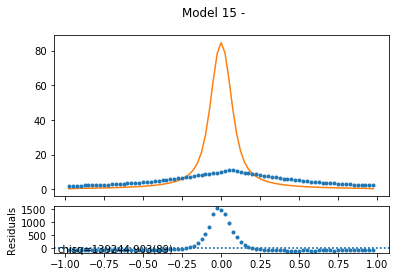

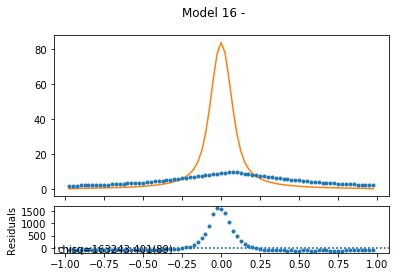

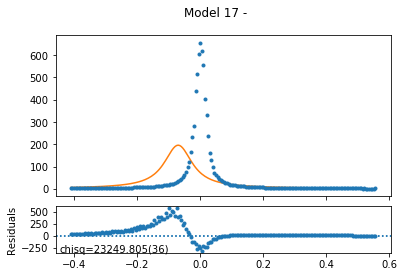

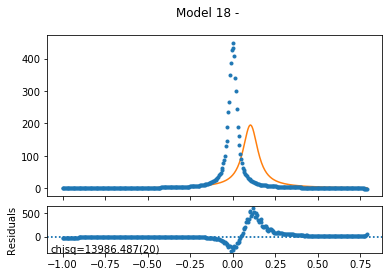

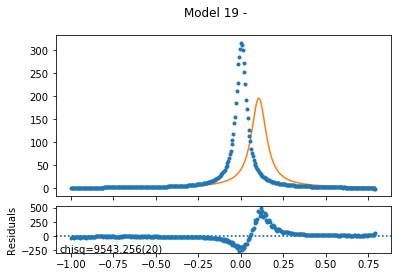

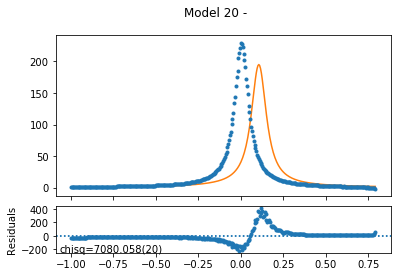

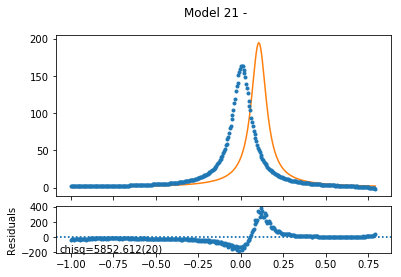

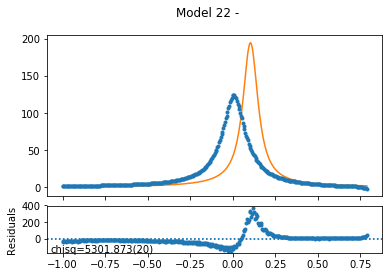

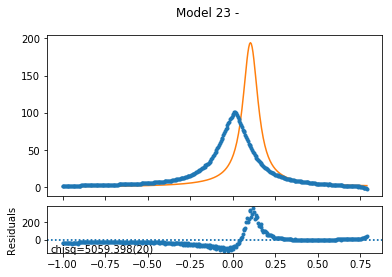

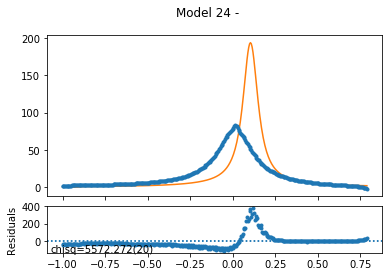

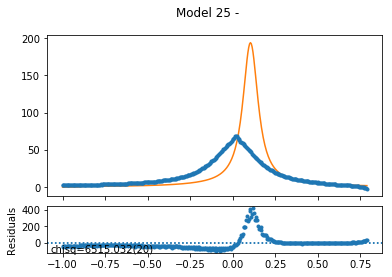

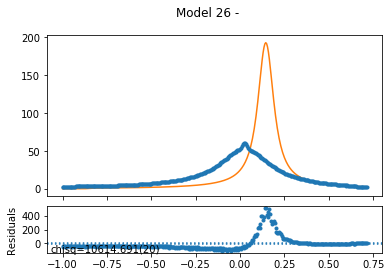

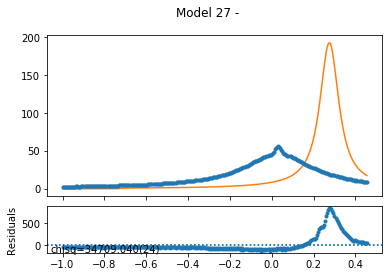

In [7]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above

In [8]:
result = fit(problem, 
             method=w_choice_minimizer.value, 
             steps=steps, 
             verbose=True)

final chisq 20737.440(31)
=== Uncertainty est. from curvature: par    dx           dx/sqrt(chisq) ===
                                      A0 0.00(66)e-3     0.0(46)e-6     
                                      A1 0.9000(22)      0.900000(15)   
                                  center 0.000(70)e-3    0.00(48)e-6    
                                   hwhm1 0.05000(19)     0.0500000(13)  
                                   hwhm2 0.3000(74)      0.300000(52)   
                                   scale 20.000(15)      20.00000(11)   
                                      A1 0.9000(23)      0.900000(16)   
                                  center 0.000(63)e-3    0.00(44)e-6    
                                   hwhm1 0.05000(20)     0.0500000(14)  
                                   hwhm2 0.3000(73)      0.300000(51)   
                                   scale 20.000(14)      20.000000(99)  
                                      A1 0.9000(25)      0.900000(17)   
                      

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

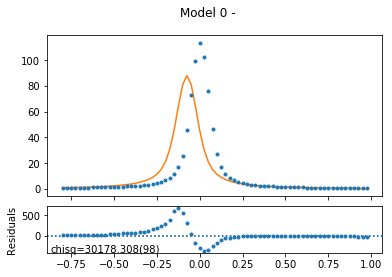

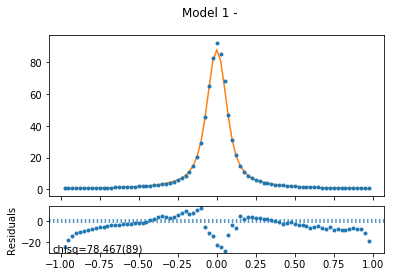

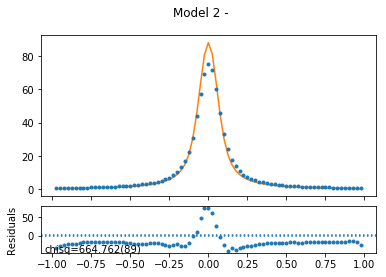

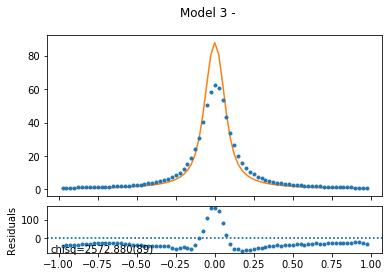

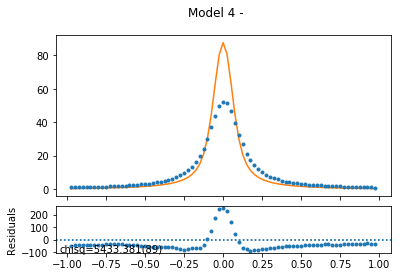

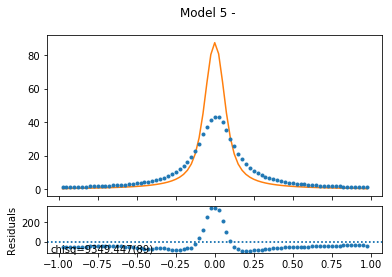

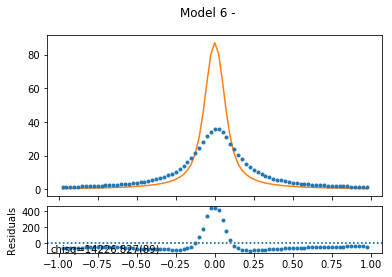

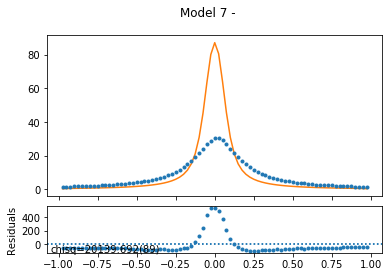

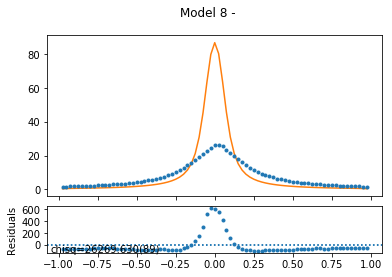

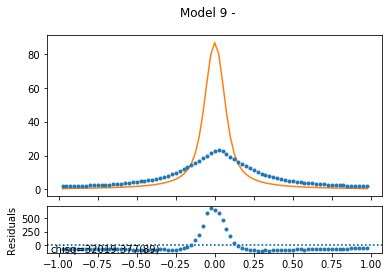

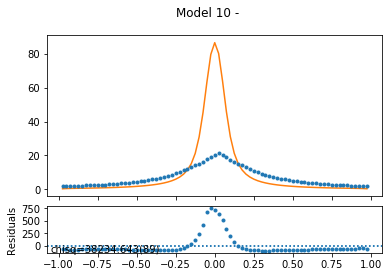

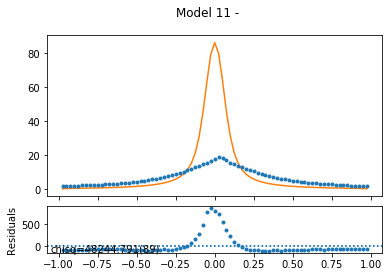

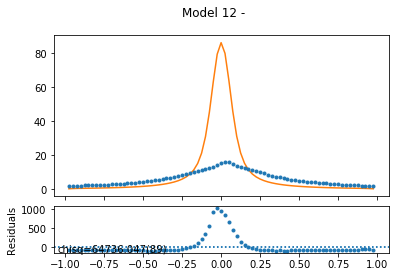

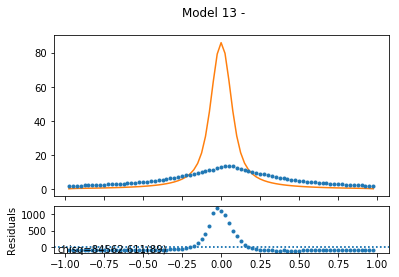

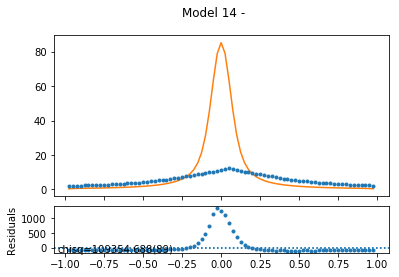

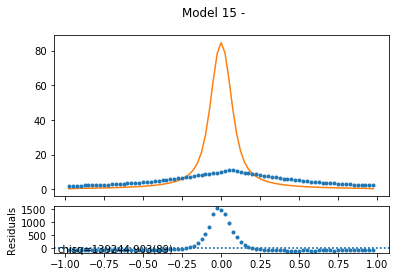

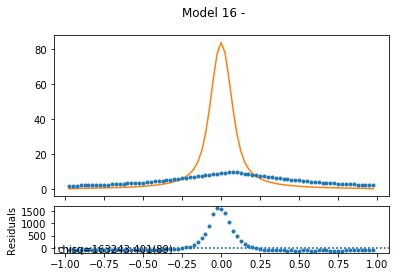

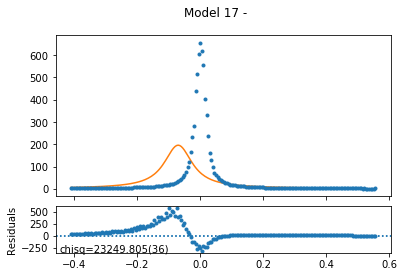

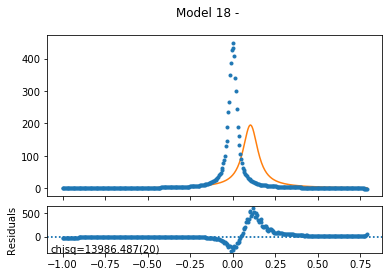

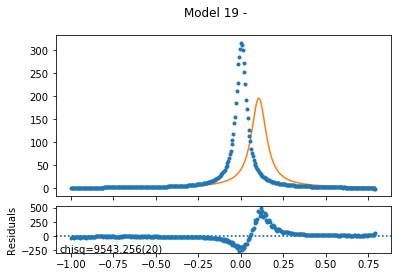

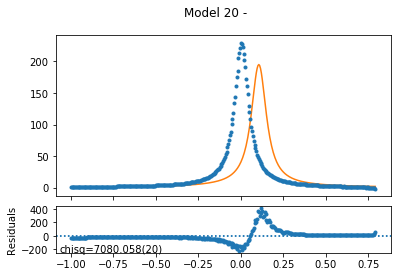

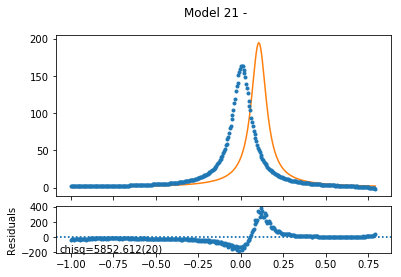

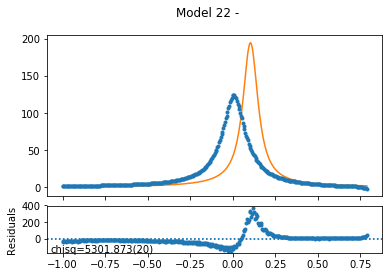

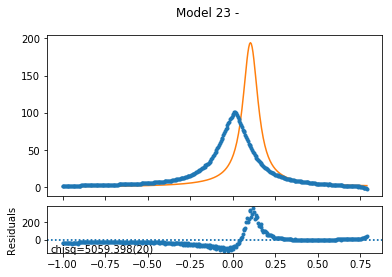

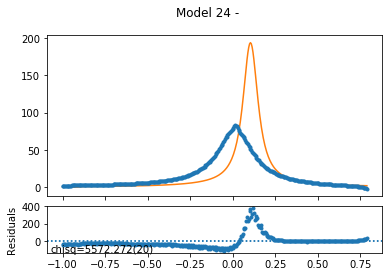

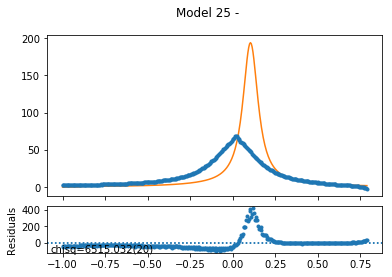

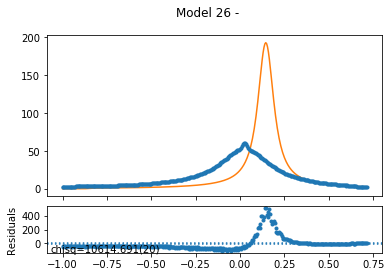

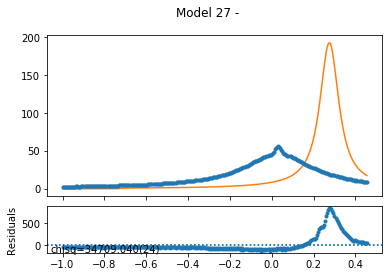

In [9]:
problem.plot()

In [10]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 20737.440(31)
A0 : 0.00(66)e-3
A1 : 0.9000(22)
center : 0.000(70)e-3
hwhm1 : 0.05000(19)
hwhm2 : 0.3000(74)
scale : 20.000(15)
A1 : 0.9000(23)
center : 0.000(63)e-3
hwhm1 : 0.05000(20)
hwhm2 : 0.3000(73)
scale : 20.000(14)
A1 : 0.9000(25)
center : 0.000(63)e-3
hwhm1 : 0.05000(21)
hwhm2 : 0.3000(79)
scale : 20.000(14)
A1 : 0.9000(26)
center : 0.000(61)e-3
hwhm1 : 0.05000(21)
hwhm2 : 0.3000(84)
scale : 20.000(14)
A1 : 0.9000(26)
center : 0.000(59)e-3
hwhm1 : 0.05000(21)
hwhm2 : 0.3000(88)
scale : 20.000(14)
A1 : 0.9000(26)
center : 0.000(55)e-3
hwhm1 : 0.05000(21)
hwhm2 : 0.3000(90)
scale : 20.000(14)
A1 : 0.9000(26)
center : 0.000(51)e-3
hwhm1 : 0.05000(20)
hwhm2 : 0.3000(91)
scale : 20.000(14)
A1 : 0.9000(25)
center : 0.000(48)e-3
hwhm1 : 0.05000(20)
hwhm2 : 0.3000(90)
scale : 20.000(14)
A1 : 0.9000(24)
center : 0.000(45)e-3
hwhm1 : 0.05000(19)
hwhm2 : 0.3000(89)
scale : 20.000(14)
A1 : 0.9000(23)
center : 0.000(42)e-3
hwhm1 : 0.05000(19)
hwhm2 : 0.3000(88)
scale : 20.000(1